In [1]:
import numpy as np
import pandas as pd
import random
import shutil
import os

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import EfficientNetB0, ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121

import warnings
warnings.filterwarnings("ignore")

# **First Technique**

## Training model to Extract features

In [ ]:
train_dir = '/kaggle/input/sip-breast-cancer/Breast_Cancer'

In [ ]:
# Image data generator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,        # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'       # For binary classification: benign vs malignant
)

In [ ]:
# Load pre-trained DenseNet without top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [ ]:
# Define model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
epochs = 10
history = model.fit(train_generator, epochs=epochs)

In [ ]:
# Optional: Unfreeze some layers and continue training
for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue fine-tuning
fine_tune_epochs = 10
history_fine = model.fit(train_generator, epochs=fine_tune_epochs)

In [ ]:
model.save('breast_cancer_dense_model_256.h5')

## Extracting Feature vectors

In [ ]:
# Load the saved model
loaded_model = load_model('/kaggle/input/sip-breast-cancer/breast_cancer_dense_model_256.h5')
feature_extractor = Model(inputs=loaded_model.input, outputs=loaded_model.layers[-2].output)  # Second last layer

In [ ]:
# Define directories
base_dir = '/kaggle/input/sip-breast-cancer/Breast_cancer_RGB/Breast_cancer_RGB'
classes = ['Benign', 'Malignant']
colors = ['Red', 'Green', 'Blue']

# Initialize a list to store the results
data = []
# Function to process an image and extract features
def extract_features(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    feature_vector = feature_extractor.predict(img_array, verbose=0)
    return feature_vector.flatten()  # Flatten the vector


# Iterate through classes
for class_label in classes:
    color_vectors = {}
    for color in colors:
        color_folder = os.path.join(base_dir, class_label, color)
        for file_name in os.listdir(color_folder):
            file_path = os.path.join(color_folder, file_name)

            # Extract features for each color component
            feature_vector = extract_features(file_path)

            # Store the feature vector in a dictionary (keyed by file name)
            if file_name not in color_vectors:
                color_vectors[file_name] = []
            color_vectors[file_name].append(feature_vector)

    # Concatenate the feature vectors for R, G, and B for each file
    for file_name, vectors in color_vectors.items():
        concatenated_vector = np.concatenate(vectors)  # Combine R, G, B vectors
        data.append((file_name, class_label, concatenated_vector))

# Organize the data for CSV
feature_size = len(data[0][2])  # Length of concatenated feature vector
columns = ['FileName', 'Class'] + [f'Feature_{i+1}' for i in range(feature_size)]
rows = []

for file_name, class_label, concatenated_vector in data:
    row = [file_name, class_label] + list(concatenated_vector)
    rows.append(row)

# Convert to a DataFrame
df = pd.DataFrame(rows, columns=columns)

In [ ]:
df.head(5)

In [ ]:
# df.to_csv('breast_cancer_combined_features.csv', index=False)

# Classification

In [77]:

test_df = pd.read_csv("/kaggle/working/test_dataset.csv")
train_df = pd.read_csv("/kaggle/working/train_dataset.csv")


In [78]:
train_df.head()

,Class,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_759,Feature_760,Feature_761,Feature_762,Feature_763,Feature_764,Feature_765,Feature_766,Feature_767,Feature_768
0,0,0.0,0.0,0.774633,0.0,0.0,1.091003,0.0,0.0,0.0,...,0.0,1.915997,0.0,0.0,0.0,0.0,1.163623,0.0,1.677841,0.0
1,1,0.0,0.0,1.462007,0.0,0.0,3.692795,0.0,0.0,0.0,...,0.0,5.049079,0.0,0.0,0.0,0.0,2.935992,0.0,7.283179,0.0
2,1,0.0,0.0,1.426378,0.0,0.0,2.552786,0.0,0.0,0.0,...,0.0,3.920422,0.0,0.0,0.0,0.0,2.947101,0.0,4.867849,0.0
3,0,0.0,0.0,0.777514,0.0,0.0,1.602724,0.0,0.0,0.0,...,0.0,3.616587,0.0,0.0,0.0,0.0,2.990533,0.0,4.200454,0.0
4,1,0.0,0.0,0.488867,0.0,0.0,2.200399,0.0,0.0,0.0,...,0.0,4.789238,0.0,0.0,0.0,0.0,5.314452,0.0,6.185259,0.0


In [81]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887 entries, 0 to 3886
Columns: 769 entries, Class to Feature_768
dtypes: float64(768), int64(1)
memory usage: 22.8 MB


In [82]:
test_df.head()

,Class,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_759,Feature_760,Feature_761,Feature_762,Feature_763,Feature_764,Feature_765,Feature_766,Feature_767,Feature_768
0,1,0.0,0.0,0.000000,0.0,0.0,0.687559,0.0,0.0,0.0,...,0.0,2.197698,0.0,0.0,0.0,0.0,2.129782,0.0,3.149723,0.0
1,1,0.0,0.0,1.659664,0.0,0.0,3.687219,0.0,0.0,0.0,...,0.0,5.257678,0.0,0.0,0.0,0.0,3.015406,0.0,7.076492,0.0
2,0,0.0,0.0,1.679442,0.0,0.0,2.862716,0.0,0.0,0.0,...,0.0,4.007412,0.0,0.0,0.0,0.0,3.216739,0.0,5.656026,0.0
3,0,0.0,0.0,0.484917,0.0,0.0,1.883503,0.0,0.0,0.0,...,0.0,3.782651,0.0,0.0,0.0,0.0,2.877728,0.0,4.510392,0.0
4,0,0.0,0.0,0.803364,0.0,0.0,2.090891,0.0,0.0,0.0,...,0.0,4.824812,0.0,0.0,0.0,0.0,2.478817,0.0,6.966157,0.0


In [83]:
# Split data into features (X) and target (y)
X_train = train_df.drop(columns=["Class"])
y_train = train_df["Class"]
X_test = test_df.drop(columns=["Class"])
y_test = test_df["Class"]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3887, 768), (687, 768), (3887,), (687,))

In [84]:
# Train Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)

In [85]:
# Calculate metrics for Logistic Regression
logistic_accuracy = accuracy_score(y_test, logistic_pred)
logistic_f1 = f1_score(y_test, logistic_pred)

print("Accuracy:", logistic_accuracy)
print("F1-Score:", logistic_f1)
# Classification report
test_report = classification_report(y_test, logistic_pred, target_names=['Class 0', 'Class 1'])
print("Test Classification Report:")
print(test_report)

Accuracy: 0.8151382823871907
F1-Score: 0.8167388167388169
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.82      0.81      0.81       342
     Class 1       0.81      0.82      0.82       345

    accuracy                           0.82       687
   macro avg       0.82      0.82      0.82       687
weighted avg       0.82      0.82      0.82       687



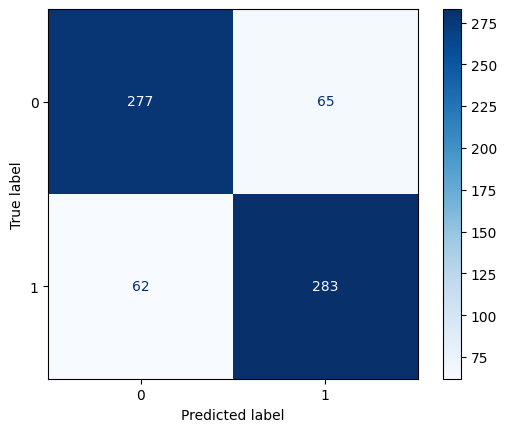

In [86]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, logistic_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logistic_model.classes_)
disp.plot(cmap='Blues');

In [87]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [88]:
# Calculate metrics for Logistic Regression
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

print("Accuracy:", rf_accuracy)
print("F1-Score:", rf_f1)
# Classification report
test_report = classification_report(y_test, rf_pred, target_names=['Class 0', 'Class 1'])
print("Test Classification Report:")
print(test_report)

Accuracy: 0.777292576419214
F1-Score: 0.7811158798283262
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.76      0.77       342
     Class 1       0.77      0.79      0.78       345

    accuracy                           0.78       687
   macro avg       0.78      0.78      0.78       687
weighted avg       0.78      0.78      0.78       687



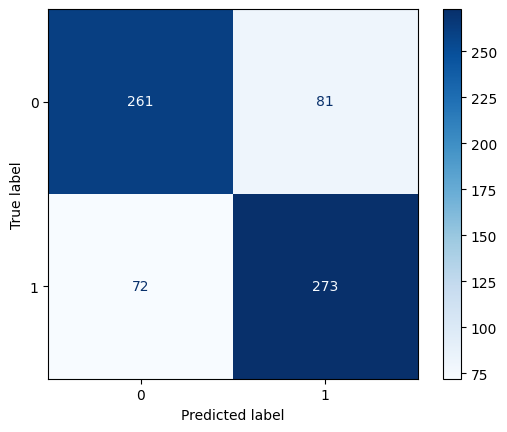

In [89]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, rf_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logistic_model.classes_)
disp.plot(cmap='Blues');

In [90]:
# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [91]:
# Calculate metrics for Logistic Regression
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)

print("Accuracy:", xgb_accuracy)
print("F1-Score:", xgb_f1)
# Classification report
test_report = classification_report(y_test, xgb_pred, target_names=['Class 0', 'Class 1'])
print("Test Classification Report:")
print(test_report)

Accuracy: 0.7874818049490538
F1-Score: 0.7884057971014492
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.79      0.79      0.79       342
     Class 1       0.79      0.79      0.79       345

    accuracy                           0.79       687
   macro avg       0.79      0.79      0.79       687
weighted avg       0.79      0.79      0.79       687



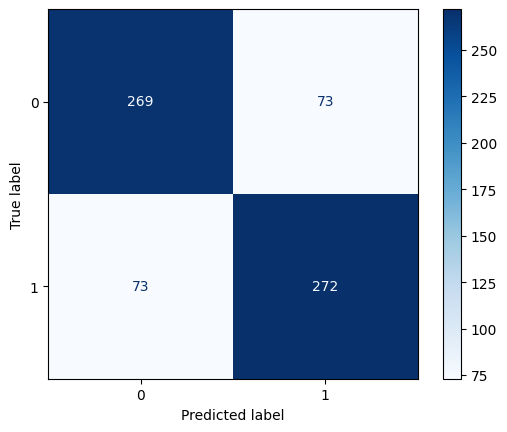

In [92]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logistic_model.classes_)
disp.plot(cmap='Blues');

# **Second Technique**

In [ ]:
base_dir = '/kaggle/input/breast-cancer-complete/Breast_Cancer_Final'
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/val"
test_dir = f"{base_dir}/test"

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values (0-1)
val_datagen = ImageDataGenerator(rescale=1./255)    # Same normalization for validation
test_datagen = ImageDataGenerator(rescale=1./255)   # Same normalization for testing

# Create data generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='binary'      # Binary classification (benign/malignant)
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False            # No shuffle for test set (for consistent predictions)
)

Found 3201 images belonging to 2 classes.
Found 686 images belonging to 2 classes.
Found 687 images belonging to 2 classes.


## Efficient NET

In [ ]:
# Load pre-trained EfficientNetB0 model (with weights trained on ImageNet)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model by adding custom layers on top of EfficientNet
model = models.Sequential([
    base_model,
    Flatten(),
    layers.Dropout(0.6),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stopping, checkpoint]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734195676.025325     122 service.cc:145] XLA service 0x798a64004bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734195676.025380     122 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734195676.025387     122 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734195725.038085     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.6856 - loss: 0.9325 - val_accuracy: 0.4971 - val_loss: 6.2904
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 375ms/step - accuracy: 0.9031 - loss: 0.2631 - val_accuracy: 0.4854 - val_loss: 1.2481
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 362ms/step - accuracy: 0.9378 - loss: 0.1965 - val_accuracy: 0.5029 - val_loss: 8.3037
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - accuracy: 0.9294 - loss: 0.2725 - val_accuracy: 0.5102 - val_loss: 0.7899
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 366ms/step - accuracy: 0.9281 - loss: 0.2537 - val_accuracy: 0.4971 - val_loss: 1.3200
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 360ms/step - accuracy: 0.9613 - loss: 0.1128 - val_accuracy: 0.5233 - val_loss: 1.2393
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 366ms/step - accuracy: 0.8303 - loss: 1.2254 - val_accuracy: 0.5816 - val_loss: 16.7334
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 362ms/step - accuracy: 0.7312 - loss: 1.3439 - val_

In [ ]:
# Re-compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[ checkpoint]
)

# Save the final model
model.save('best_model.keras')

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 148s 798ms/step - accuracy: 0.9087 - loss: 0.4197 - val_accuracy: 0.4942 - val_loss: 1.8369
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 356ms/step - accuracy: 0.9082 - loss: 0.4327 - val_accuracy: 0.5306 - val_loss: 1.7328
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 355ms/step - accuracy: 0.9493 - loss: 0.1517 - val_accuracy: 0.6793 - val_loss: 1.4320
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 356ms/step - accuracy: 0.9194 - loss: 0.5039 - val_accuracy: 0.5525 - val_loss: 32.0699
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 351ms/step - accuracy: 0.8797 - loss: 0.5591 - val_accuracy: 0.6283 - val_loss: 116.0774
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 352ms/step - accuracy: 0.8629 - loss: 0.9962 - val_accuracy: 0.6851 - val_loss: 2.2702
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 362ms/step - accuracy: 0.8106 - loss: 1.1443 - val_accuracy: 0.7624 - val_loss: 1.0259
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.8653 - los

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step - accuracy: 0.9491 - loss: 0.2094
Test Loss: 0.5980, Test Accuracy: 0.8574


In [ ]:
# Generate predictions for the test set
y_test_pred = (model.predict(test_gen) > 0.5).astype(int).flatten()  # Threshold at 0.5
y_test_true = test_gen.classes  # True labels from the test set

22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 529ms/step


Test Confusion Matrix:
[[340   2]
 [ 96 249]]
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.99      0.87       342
     Class 1       0.99      0.72      0.84       345

    accuracy                           0.86       687
   macro avg       0.89      0.86      0.85       687
weighted avg       0.89      0.86      0.85       687



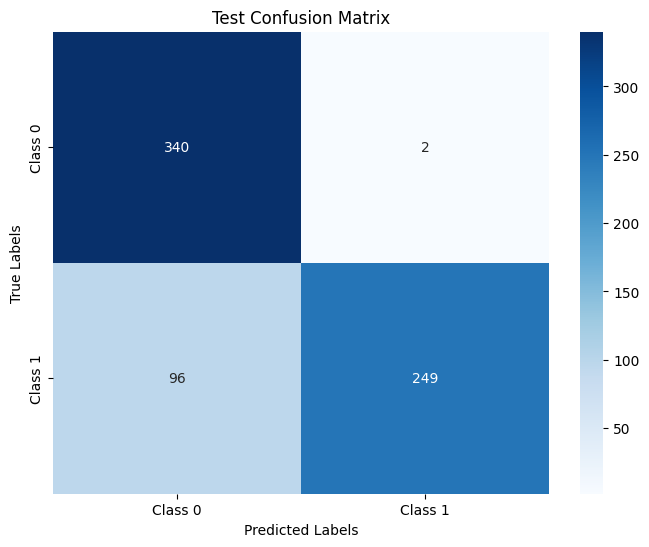

In [ ]:
# Confusion matrix
test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)
print("Test Confusion Matrix:")
print(test_conf_matrix)

# Classification report
test_report = classification_report(y_test_true, y_test_pred, target_names=['Class 0', 'Class 1'])
print("Test Classification Report:")
print(test_report)

# Visualize confusion matrix


plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


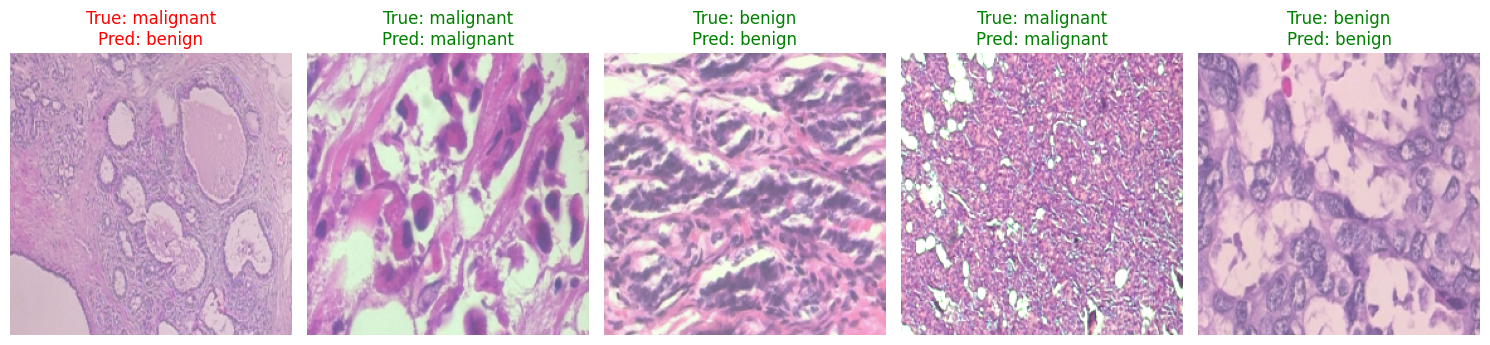

In [ ]:
# Get 5 random indices from the test set
random_indices = random.sample(range(test_gen.samples), 5)

# Load the test images and labels
test_images, test_labels = [], []

for idx in random_indices:
    test_gen.reset()  # Reset the generator
    batch_index = idx // test_gen.batch_size
    within_batch_index = idx % test_gen.batch_size

    # Get the corresponding batch
    for i, (images, labels) in enumerate(test_gen):
        if i == batch_index:
            test_images.append(images[within_batch_index])
            test_labels.append(labels[within_batch_index])
            break

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Predict on the 5 random images
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Class labels mapping
class_indices = test_gen.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Plot the images with their true and predicted labels
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    true_label = class_labels[int(test_labels[i])]
    predicted_label = class_labels[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12, color="green" if true_label == predicted_label else "red")
plt.tight_layout()
plt.show()

## ResNet 101

In [ ]:
# Load pre-trained ResNet101 model (with weights trained on ImageNet)
base_model_resnet = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Rebuild the model
model_resnet = models.Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),  # Better than Flatten
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.8),  # Regularization
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_resnet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_resnet101_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model_resnet.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734252973.180438    2034 service.cc:145] XLA service 0x7979b413d780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734252973.180495    2034 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734252973.180501    2034 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734253025.469782    2034 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers a

 38/101 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.5513 - loss: 1.1442

I0000 00:00:1734253082.852745    2034 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_42', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_94', 40 bytes spill stores, 40 bytes spill loads



101/101 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.5658 - loss: 1.1140 - val_accuracy: 0.4971 - val_loss: 2584310.7500
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 62s 587ms/step - accuracy: 0.6116 - loss: 0.7080 - val_accuracy: 0.4971 - val_loss: 0.7084
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 562ms/step - accuracy: 0.6848 - loss: 0.6050 - val_accuracy: 0.4971 - val_loss: 0.7437
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 566ms/step - accuracy: 0.7358 - loss: 0.5512 - val_accuracy: 0.4971 - val_loss: 0.8218
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 561ms/step - accuracy: 0.8121 - loss: 0.4490 - val_accuracy: 0.4971 - val_loss: 0.9552
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 560ms/step - accuracy: 0.8408 - loss: 0.3836 - val_accuracy: 0.4971 - val_loss: 1.1262
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 561ms/step - accuracy: 0.8640 - loss: 0.3314 - val_accuracy: 0.4971 - val_loss: 1.2497


In [ ]:
# Re-compile the model for fine-tuning
model_resnet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_finetune = model_resnet.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[checkpoint]
)

# Save the final model
model_resnet.save('best_resnet101_model.keras')

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 195s 974ms/step - accuracy: 0.6398 - loss: 0.6666 - val_accuracy: 0.5029 - val_loss: 15872.1367
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 561ms/step - accuracy: 0.7286 - loss: 0.5900 - val_accuracy: 0.4971 - val_loss: 0.7925
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 554ms/step - accuracy: 0.7722 - loss: 0.5521 - val_accuracy: 0.5029 - val_loss: 0.7707
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 562ms/step - accuracy: 0.8138 - loss: 0.4485 - val_accuracy: 0.5058 - val_loss: 0.9161
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 564ms/step - accuracy: 0.8487 - loss: 0.3750 - val_accuracy: 0.4971 - val_loss: 1.1989
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 564ms/step - accuracy: 0.8828 - loss: 0.3301 - val_accuracy: 0.5160 - val_loss: 0.7785
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 559ms/step - accuracy: 0.7345 - loss: 0.5524 - val_accuracy: 0.5117 - val_loss: 1.0627
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 563ms/step - accuracy: 0.8289 - lo

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for the test set
y_test_pred_resnet = (model_resnet.predict(test_gen) > 0.5).astype(int).flatten()  # Threshold at 0.5
y_test_true = test_gen.classes  # True labels from the test set

22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 708ms/step - accuracy: 0.7410 - loss: 22.5609
Test Loss: 14.2040, Test Accuracy: 0.7540
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 506ms/step


Test Confusion Matrix:
[[259  83]
 [ 86 259]]
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.76      0.75       342
     Class 1       0.76      0.75      0.75       345

    accuracy                           0.75       687
   macro avg       0.75      0.75      0.75       687
weighted avg       0.75      0.75      0.75       687



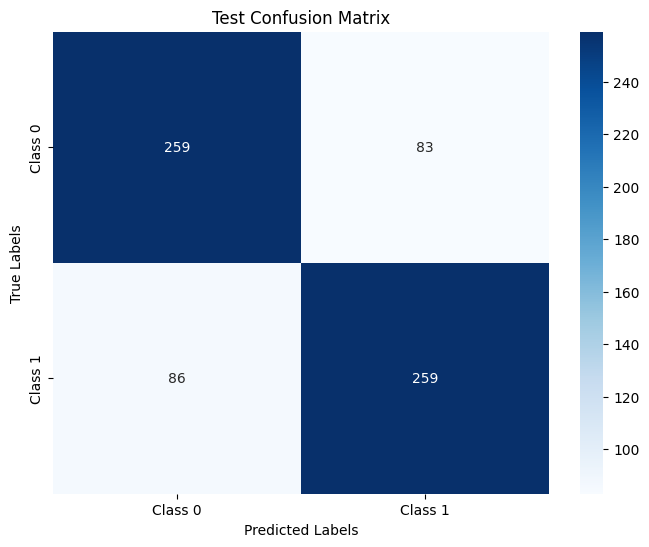

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
test_conf_matrix = confusion_matrix(y_test_true, y_test_pred_resnet)
print("Test Confusion Matrix:")
print(test_conf_matrix)

# Classification report
test_report = classification_report(y_test_true, y_test_pred_resnet, target_names=['Class 0', 'Class 1'])
print("Test Classification Report:")
print(test_report)

# Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


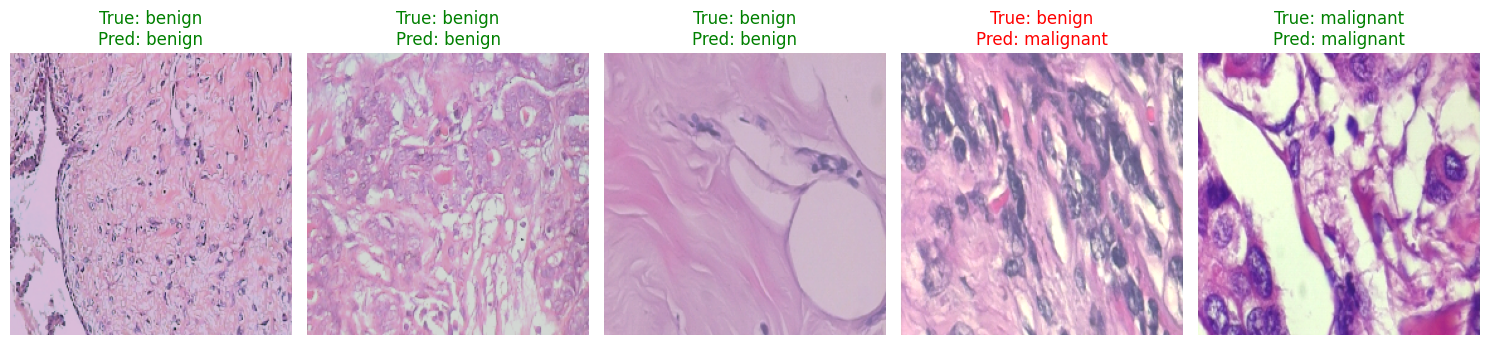

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model

# Get 5 random indices from the test set
random_indices = random.sample(range(test_gen.samples), 5)

# Load the test images and labels
test_images, test_labels = [], []

for idx in random_indices:
    test_gen.reset()  # Reset the generator
    batch_index = idx // test_gen.batch_size
    within_batch_index = idx % test_gen.batch_size

    # Get the corresponding batch
    for i, (images, labels) in enumerate(test_gen):
        if i == batch_index:
            test_images.append(images[within_batch_index])
            test_labels.append(labels[within_batch_index])
            break

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Predict on the 5 random images
predictions = model_resnet.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Class labels mapping
class_indices = test_gen.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Plot the images with their true and predicted labels
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    true_label = class_labels[int(test_labels[i])]
    predicted_label = class_labels[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12, color="green" if true_label == predicted_label else "red")
plt.tight_layout()
plt.show()